Text(0.5, 1.0, 'by hour')

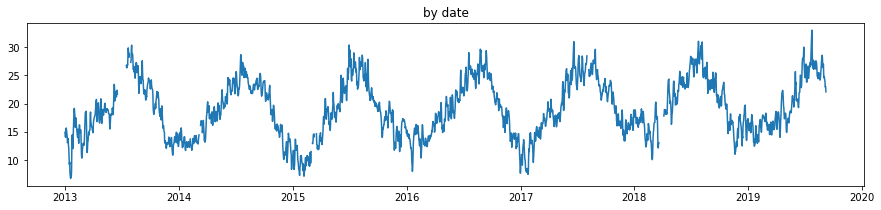

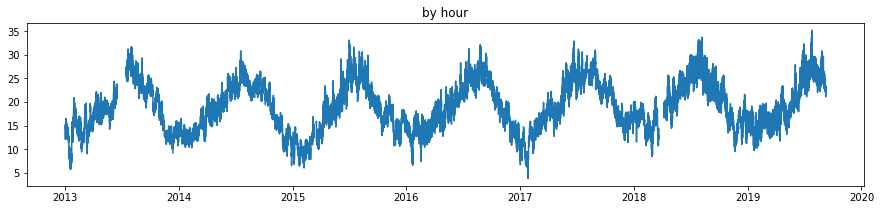

In [10]:
# load JSON
import json
import pandas as pd
 
# hourly data 
data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-temp.pkl')
data = data.sort_values(by=['ds'])
data['just_date'] = data['ds'].dt.date
df_h = data

# group by date
data_d = data.groupby(['just_date'],squeeze=True).mean()
data_d.columns = ['_'.join(col).strip() for col in data_d.columns.values]
data_d = data_d.reset_index()
data_d.columns = ['ds','y'] # rename column
df_d = data_d

import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
plt.figure(figsize=(15,3))
plt.plot(df_d['ds'],df_d['y'])
plt.title('by date')
plt.figure(figsize=(15,3))
plt.plot(df_h['ds'],df_h['y'])
plt.title('by hour')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


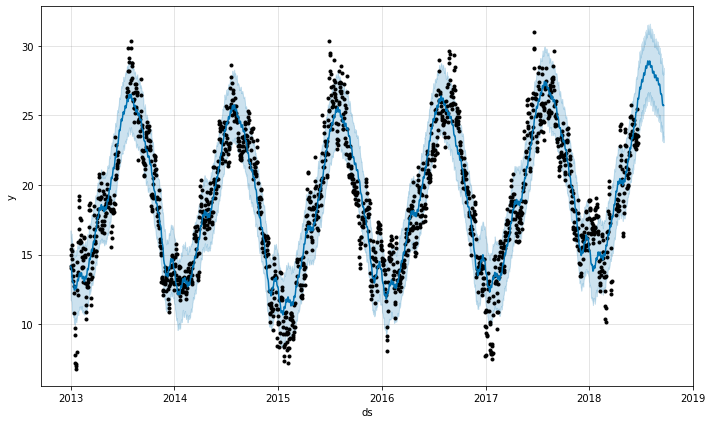

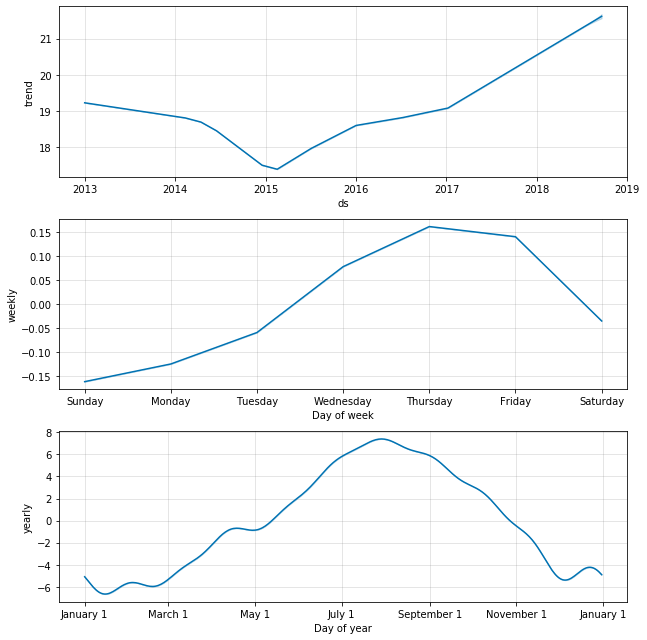

In [7]:
df = df_d # select daily or hourly daya

from fbprophet import Prophet

m = Prophet(changepoint_prior_scale=0.1) #  Increasing scale will make the trend more flexible:
m.fit(df)
future = m.make_future_dataframe(periods=2160, freq='H')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
fig = m.plot(forecast)
components_fig = m.plot_components(forecast)

In [5]:
# PROPHET validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='270 days', period='30 days', horizon ='90 days') # horizon: forecast ; initial: training (default: 3x horizon); 
df_cv.head()

INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-05-19 05:00:00 and 2018-06-18 05:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-05-19 06:00:00,51.651700,-6.791366,114.305234,29.0,2018-05-19 05:00:00
1,2018-05-19 07:00:00,30.851017,-35.313616,93.354560,33.0,2018-05-19 05:00:00
2,2018-05-19 08:00:00,19.589972,-45.607986,77.883116,46.0,2018-05-19 05:00:00
3,2018-05-19 09:00:00,21.007126,-37.023345,84.674155,37.0,2018-05-19 05:00:00
4,2018-05-19 10:00:00,31.754562,-26.937400,94.038879,35.0,2018-05-19 05:00:00


In [8]:
target_column = ['y'] 
predictors = list(set(list(df.columns))-set(target_column))
df[predictors] = df[predictors]/df[predictors].max()
df.describe().transpose()

TypeError: cannot perform __truediv__ with this index type: DatetimeIndex

In [7]:
# Percentage errors
mape = 100*sum(abs( (df_cv.yhat - df_cv.y) / df_cv.y) ) / len(df_cv) # MAPE
smape = 100*sum( abs(df_cv.yhat - df_cv.y) / (abs(df_cv.yhat) + abs(df_cv.y)) ) /len(df_cv) / 2 # SMAPE
print('MAPE = ' + str(mape) + '%')
print('SMAPE = ' + str(smape) + '%')

MAPE = 64.57306872605503%
SMAPE = 15.490363068799178%


In [ ]:
#import pickle
#pkl_path = "franklin-d-roosevelt/PM10_m.pkl"
#with open(pkl_path, "wb") as f:
#    # Pickle the 'Prophet' model using the highest protocol available.
#    pickle.dump(m, f)

## save the dataframe
#forecast.to_pickle("franklin-d-roosevelt/PM10_forecast.pkl")
#print("*** Data Saved ***")

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(forecast.ds,forecast.yhat,marker='.')
#plt.figure(figsize=(15,3))
plt.plot(data_d.ds[50001:52160],data_d.y[50001:52160])